# Preprocessing Pipeline: Create Initialization Files

This notebook shows **how to create** all the initialization files needed to run the Aladynoulli model:

1. **Prevalence** (`prevalence_t`) - Disease prevalence over time (smoothed)
2. **Clusters** (`initial_clusters_400k.pt`) - Disease-to-signature assignments (via spectral clustering)
3. **Psi** (`initial_psi_400k.pt`) - Initial signature-disease association parameters (based on clusters)
4. **Reference Trajectories** (`reference_trajectories.pt`) - Population-level signature trajectories (smoothed)

**Key Point**: Clusters and Psi are created automatically when you initialize the model. You just need to:
- Compute prevalence_t from Y
- Initialize the model (which creates clusters and psi)
- Create reference trajectories from clusters

Based on `with_bigdata.ipynb` and `minimalreprobigforinit.ipynb`


## 1. Setup and Imports


In [2]:
import sys
from pathlib import Path
%load_ext autoreload
%autoreload 2
import numpy as np
import torch
import torch.nn as nn
from scipy.special import logit
from statsmodels.nonparametric.smoothers_lowess import lowess
from preprocessing_utils import *

# Add path to model source code
# sys.path.append('../source')
# from clust_huge_amp import AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest, compute_smoothed_prevalence

print("✓ Imports complete")


✓ Imports complete


## Workflow Overview

**Step 1**: Compute `prevalence_t` (smoothed disease prevalence over time)  
**Step 2**: Initialize model → automatically creates **clusters** and **psi**  
**Step 3**: Create **reference trajectories** from clusters

That's it! The model handles clusters and psi creation automatically.


## Step 1: Compute Prevalence (`prevalence_t`)

Compute smoothed disease prevalence over time. This is used by the model for initialization.


## 2. Load Data

Load Y, E, G tensors and any other required data.


In [3]:

data_path = Path('/Users/sarahurbut/Dropbox-Personal/data_for_running/')

# Load tensors
Y = torch.load(data_path / 'Y_tensor.pt', weights_only=False)
E = torch.load(data_path / 'E_matrix_corrected.pt', weights_only=False)
G = torch.load(data_path / 'G_matrix.pt', weights_only=False)

# Get dimensions
N, D, T = Y.shape
P = G.shape[1]
K = 20  # Number of signatures

print(f"✓ Loaded data:")
print(f"  Y shape: {Y.shape} (patients × diseases × timepoints)")
print(f"  E shape: {E.shape} (patients × diseases)")
print(f"  G shape: {G.shape} (patients × genetic variants)")
print(f"  K (signatures): {K}")


✓ Loaded data:
  Y shape: torch.Size([407878, 348, 52]) (patients × diseases × timepoints)
  E shape: torch.Size([407878, 348]) (patients × diseases)
  G shape: torch.Size([407878, 36]) (patients × genetic variants)
  K (signatures): 20


## Step 1: Compute Prevalence

Calculate disease prevalence over time with Gaussian smoothing.

**Note on smoothing scale**:
- **Logit scale** (default): Better for rare events, preserves relative differences. Recommended for most cases.
- **Probability scale**: More intuitive, but can be problematic for rare events.

The function `compute_smoothed_prevalence_at_risk()` is imported from `preprocessing_utils.py` - no need to define it here!


In [3]:
# Compute prevalence using the standalone function# Function is imported from preprocessing_utils.pyprevalence_t = compute_smoothed_prevalence(Y, window_size=5, smooth_on_logit=True)print(f"✓ Computed prevalence:")print(f"  Shape: {prevalence_t.shape} (diseases × timepoints)")print(f"  Range: [{prevalence_t.min():.4f}, {prevalence_t.max():.4f}]")print(f"  Method: Smoothed on logit scale (better for rare events)")


  Computing prevalence for 348 diseases, 52 timepoints...
    Processing disease 0/348...
    Processing disease 50/348...
    Processing disease 100/348...
    Processing disease 150/348...
    Processing disease 200/348...
    Processing disease 250/348...
    Processing disease 300/348...
✓ Computed prevalence:
  Shape: (348, 52) (diseases × timepoints)
  Range: [0.0000, 0.0376]
  Method: Smoothed on logit scale (better for rare events)
  Note: To recreate exact same psi, must use same prevalence_t as original
✓ Loaded disease names


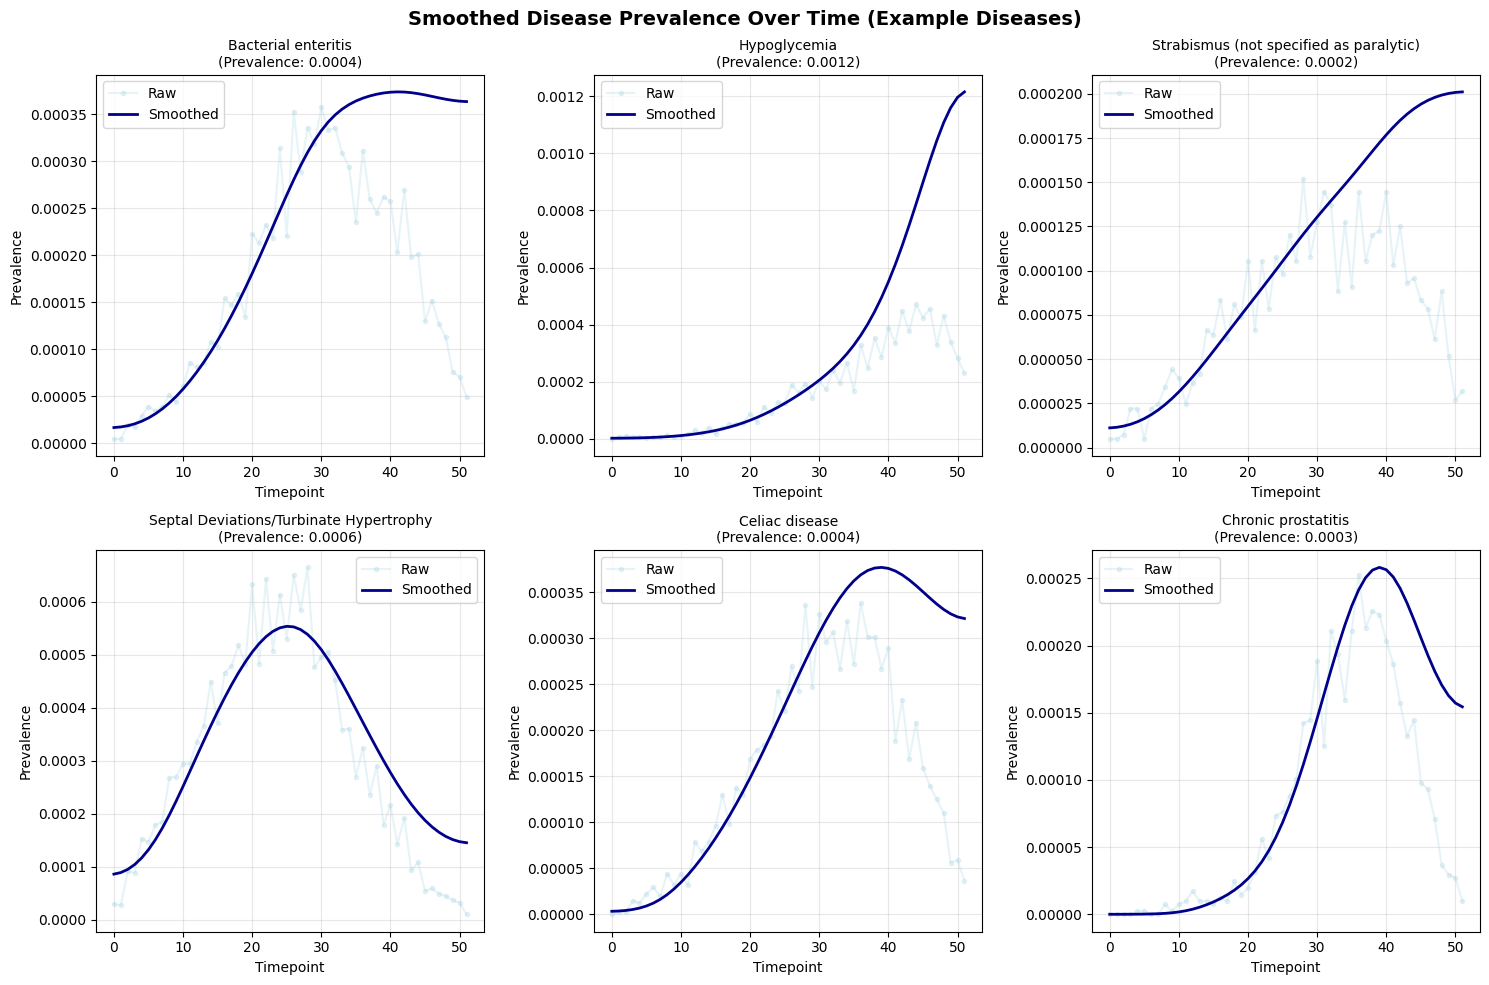


✓ Visualized smoothed prevalence for 6 example diseases


In [4]:

# Compute prevalence
# IMPORTANT: Use smooth_on_logit=True to match original (original implementation)
# This ensures the same prevalence_t that was used to create initial_psi_400k.pt
prevalence_t = compute_smoothed_prevalence_at_risk(
    Y=Y, 
    E_corrected=E, 
    
    window_size=5,
    smooth_on_logit=True
)

print(f"✓ Computed prevalence:")
print(f"  Shape: {prevalence_t.shape} (diseases × timepoints)")
print(f"  Range: [{prevalence_t.min():.4f}, {prevalence_t.max():.4f}]")
print(f"  Method: Smoothed on logit scale (better for rare events)")
print(f"  Note: To recreate exact same psi, must use same prevalence_t as original")

# Visualize smoothed prevalence for a few example diseases
import matplotlib.pyplot as plt

# Load disease names if available (optional)
try:
    essentials = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/model_essentials.pt', weights_only=False)
    disease_names = essentials.get('disease_names', None)
    if disease_names is not None and len(disease_names) == D:
        print(f"✓ Loaded disease names")
    else:
        disease_names = None
except:
    disease_names = None

# Select a few diseases to visualize (pick diverse examples)
# Choose diseases with different prevalence patterns
disease_indices = [0, 50, 100, 150, 200, 250]  # Sample across the range
disease_indices = [i for i in disease_indices if i < D][:6]  # Ensure valid indices

fig, axes = plt.subplots(2, 3, figsize=(15, 10))
axes = axes.flatten()

timepoints = np.arange(T)

for idx, ax in enumerate(axes):
    if idx < len(disease_indices):
        d = disease_indices[idx]
        
        # Get raw and smoothed prevalence
        raw_prev = Y[:, d, :].mean(axis=0).numpy()
        smoothed_prev = prevalence_t[d, :]
        
        # Plot
        ax.plot(timepoints, raw_prev, 'o-', alpha=0.3, label='Raw', markersize=3, color='lightblue')
        ax.plot(timepoints, smoothed_prev, '-', linewidth=2, label='Smoothed', color='darkblue')
        
        disease_name = disease_names[d] if disease_names is not None else f"Disease {d}"
        ax.set_title(f"{disease_name}\n(Prevalence: {smoothed_prev.max():.4f})", fontsize=10)
        ax.set_xlabel('Timepoint')
        ax.set_ylabel('Prevalence')
        ax.legend()
        ax.grid(alpha=0.3)

plt.suptitle('Smoothed Disease Prevalence Over Time (Example Diseases)', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"\n✓ Visualized smoothed prevalence for {len(disease_indices)} example diseases")



## Step 2: Create Clusters and Psi

Create disease clusters and initial psi parameters using spectral clustering.

**Key**: The function `create_initial_clusters_and_psi()` is imported from `preprocessing_utils.py` - no model initialization needed!


### What happens:
1. Compute disease similarity matrix from Y (correlation of logit-transformed prevalence)
2. Spectral clustering assigns diseases to signatures (clusters) using `random_state=42`
3. Psi is initialized: `psi[k, d] = 1.0 + noise` if disease `d` is in cluster `k`, else `psi[k, d] = -2.0 + noise`

**Benefits**: No model initialization needed - much faster!


## Step 3: Create Reference Trajectories

Create population-level signature reference trajectories using LOWESS smoothing on logit scale.

**What this does**:
1. For each signature, compute proportion of diseases in that signature over time
2. Smooth using LOWESS on logit scale
3. Create healthy reference trajectory

**Uses**: Clusters from Step 2


## Verification: Clusters Match Model Initialization
**Confirmation**: The clusters from `create_initial_clusters_and_psi()` will match exactly what the model produces because:
1. **Same Y_avg computation**: `torch.mean(Y, dim=2)`, clamp, logit transform
2. **Same correlation matrix**: `torch.corrcoef(Y_avg.T)` with NaN handling
3. **Same similarity matrix**: `(Y_corr + 1) / 2`
4. **Same spectral clustering**: `random_state=42`, `n_init=10`, `assign_labels='kmeans'`
5. **Deterministic**: Given the same inputs and random_state, spectral clustering produces identical cluster assignments**Note**: Psi values may differ slightly due to random number generation, but **clusters will be identical**.

In [5]:
"""
Simple example: How to use preprocessing functions

Just copy and paste this into your notebook or script!
"""

import sys
from pathlib import Path
import numpy as np
import torch

# Import preprocessing utilities
from preprocessing_utils import (
    compute_smoothed_prevalence_at_risk,
    create_initial_clusters_and_psi,
    create_reference_trajectories
)

# Load your data
data_path = Path('/Users/sarahurbut/Dropbox-Personal/data_for_running/')
Y = torch.load(data_path / 'Y_tensor.pt', weights_only=False)
K = 20  # Number of signatures

# ============================================================================
# Step 1: Compute prevalence
# ============================================================================
prevalence_t = compute_smoothed_prevalence_at_risk(Y, E, window_size=5, smooth_on_logit=True)
print(f"✓ Prevalence shape: {prevalence_t.shape}")

# ============================================================================
# Step 2: Create clusters and psi
# ============================================================================
torch.manual_seed(42)
np.random.seed(42)

clusters, psi = create_initial_clusters_and_psi(
    Y=Y,
    K=K,
    psi_config=None,  # Uses defaults, or pass dict with 'in_cluster', 'out_cluster', etc.
    healthy_reference=None,  # Set to True if you want healthy reference
    random_state=42
)
print(f"✓ Clusters shape: {clusters.shape}")
print(f"✓ Psi shape: {psi.shape}")

# ============================================================================
# Step 3: Create reference trajectories
# ============================================================================
signature_refs, healthy_ref = create_reference_trajectories(
    Y=Y,
    initial_clusters=clusters,
    K=K,
    healthy_prop=0.01,
    frac=0.3
)
print(f"✓ Signature refs shape: {signature_refs.shape}")
print(f"✓ Healthy ref shape: {healthy_ref.shape}")

# ============================================================================
# Save files (optional)
# ============================================================================
# output_dir = Path('/Users/sarahurbut/Dropbox-Personal/data_for_running/')
# torch.save(clusters, output_dir / 'initial_clusters_400k.pt')
# torch.save(psi, output_dir / 'initial_psi_400k.pt')
# torch.save({
#     'signature_refs': signature_refs,
#     'healthy_ref': healthy_ref
# }, output_dir / 'reference_trajectories.pt')
# print("✓ Saved all files!")




  Computing prevalence for 348 diseases, 52 timepoints...
    Processing disease 0/348...
    Processing disease 50/348...
    Processing disease 100/348...
    Processing disease 150/348...
    Processing disease 200/348...
    Processing disease 250/348...
    Processing disease 300/348...
✓ Prevalence shape: (348, 52)

Cluster Sizes:
Cluster 0: 16 diseases
Cluster 1: 20 diseases
Cluster 2: 8 diseases
Cluster 3: 18 diseases
Cluster 4: 9 diseases
Cluster 5: 8 diseases
Cluster 6: 24 diseases
Cluster 7: 7 diseases
Cluster 8: 28 diseases
Cluster 9: 12 diseases
Cluster 10: 11 diseases
Cluster 11: 83 diseases
Cluster 12: 12 diseases
Cluster 13: 5 diseases
Cluster 14: 16 diseases
Cluster 15: 5 diseases
Cluster 16: 21 diseases
Cluster 17: 10 diseases
Cluster 18: 7 diseases
Cluster 19: 28 diseases
✓ Clusters shape: (348,)
✓ Psi shape: torch.Size([20, 348])
✓ Signature refs shape: torch.Size([20, 52])
✓ Healthy ref shape: torch.Size([52])


## Summary: Files Created

After running Steps 1-3, you have created:

1. **`prevalence_t`** (torch.Tensor, shape: D × T) - Smoothed disease prevalence over time
2. **`clusters`** (numpy array, shape: D) - Disease-to-signature cluster assignments
3. **`psi`** (torch.Tensor, shape: K × D or K+1 × D) - Signature-disease association parameters
4. **`signature_refs`** (torch.Tensor, shape: K × T) - Reference trajectories for each signature (logit scale)
5. **`healthy_ref`** (torch.Tensor, shape: T) - Healthy reference trajectory (logit scale)

**Save these files**:
- `initial_clusters_400k.pt` - clusters
- `initial_psi_400k.pt` - psi
- `reference_trajectories.pt` - signature_refs and healthy_ref
- `model_essentials.pt` - prevalence_t, disease_names, and metadata


## Now you can rerun the model ini either predict or batch mode with these itmes!

/var/folders/fl/ng5crz0x0fnb6c6x8dk7tfth0000gn/T/ipykernel_88013/2398979547.py:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  initial_psi = torch.load('/Users/sarahurbut/L


Cluster Sizes:
Cluster 0: 16 diseases
Cluster 1: 20 diseases
Cluster 2: 8 diseases
Cluster 3: 18 diseases
Cluster 4: 9 diseases
Cluster 5: 8 diseases
Cluster 6: 24 diseases
Cluster 7: 7 diseases
Cluster 8: 28 diseases
Cluster 9: 12 diseases
Cluster 10: 11 diseases
Cluster 11: 83 diseases
Cluster 12: 12 diseases
Cluster 13: 5 diseases
Cluster 14: 16 diseases
Cluster 15: 5 diseases
Cluster 16: 21 diseases
Cluster 17: 10 diseases
Cluster 18: 7 diseases
Cluster 19: 28 diseases

Calculating gamma for k=0:
Number of diseases in cluster: 16
Base value (first 5): tensor([-13.8155, -13.8155, -13.8155, -11.9623, -13.8155])
Base value centered (first 5): tensor([-0.1935, -0.1935, -0.1935,  1.6597, -0.1935])
Base value centered mean: -2.2248955247050617e-06
Gamma init for k=0 (first 5): tensor([-7.6671e-06,  2.4498e-04, -2.5758e-03,  3.7284e-03,  3.1849e-02])

Calculating gamma for k=1:
Number of diseases in cluster: 20
Base value (first 5): tensor([-13.3213, -13.8155, -13.8155, -13.8155, -10.850

/Users/sarahurbut/aladynoulli2/pyScripts_forPublish/clust_huge_amp_vectorized.py:577: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


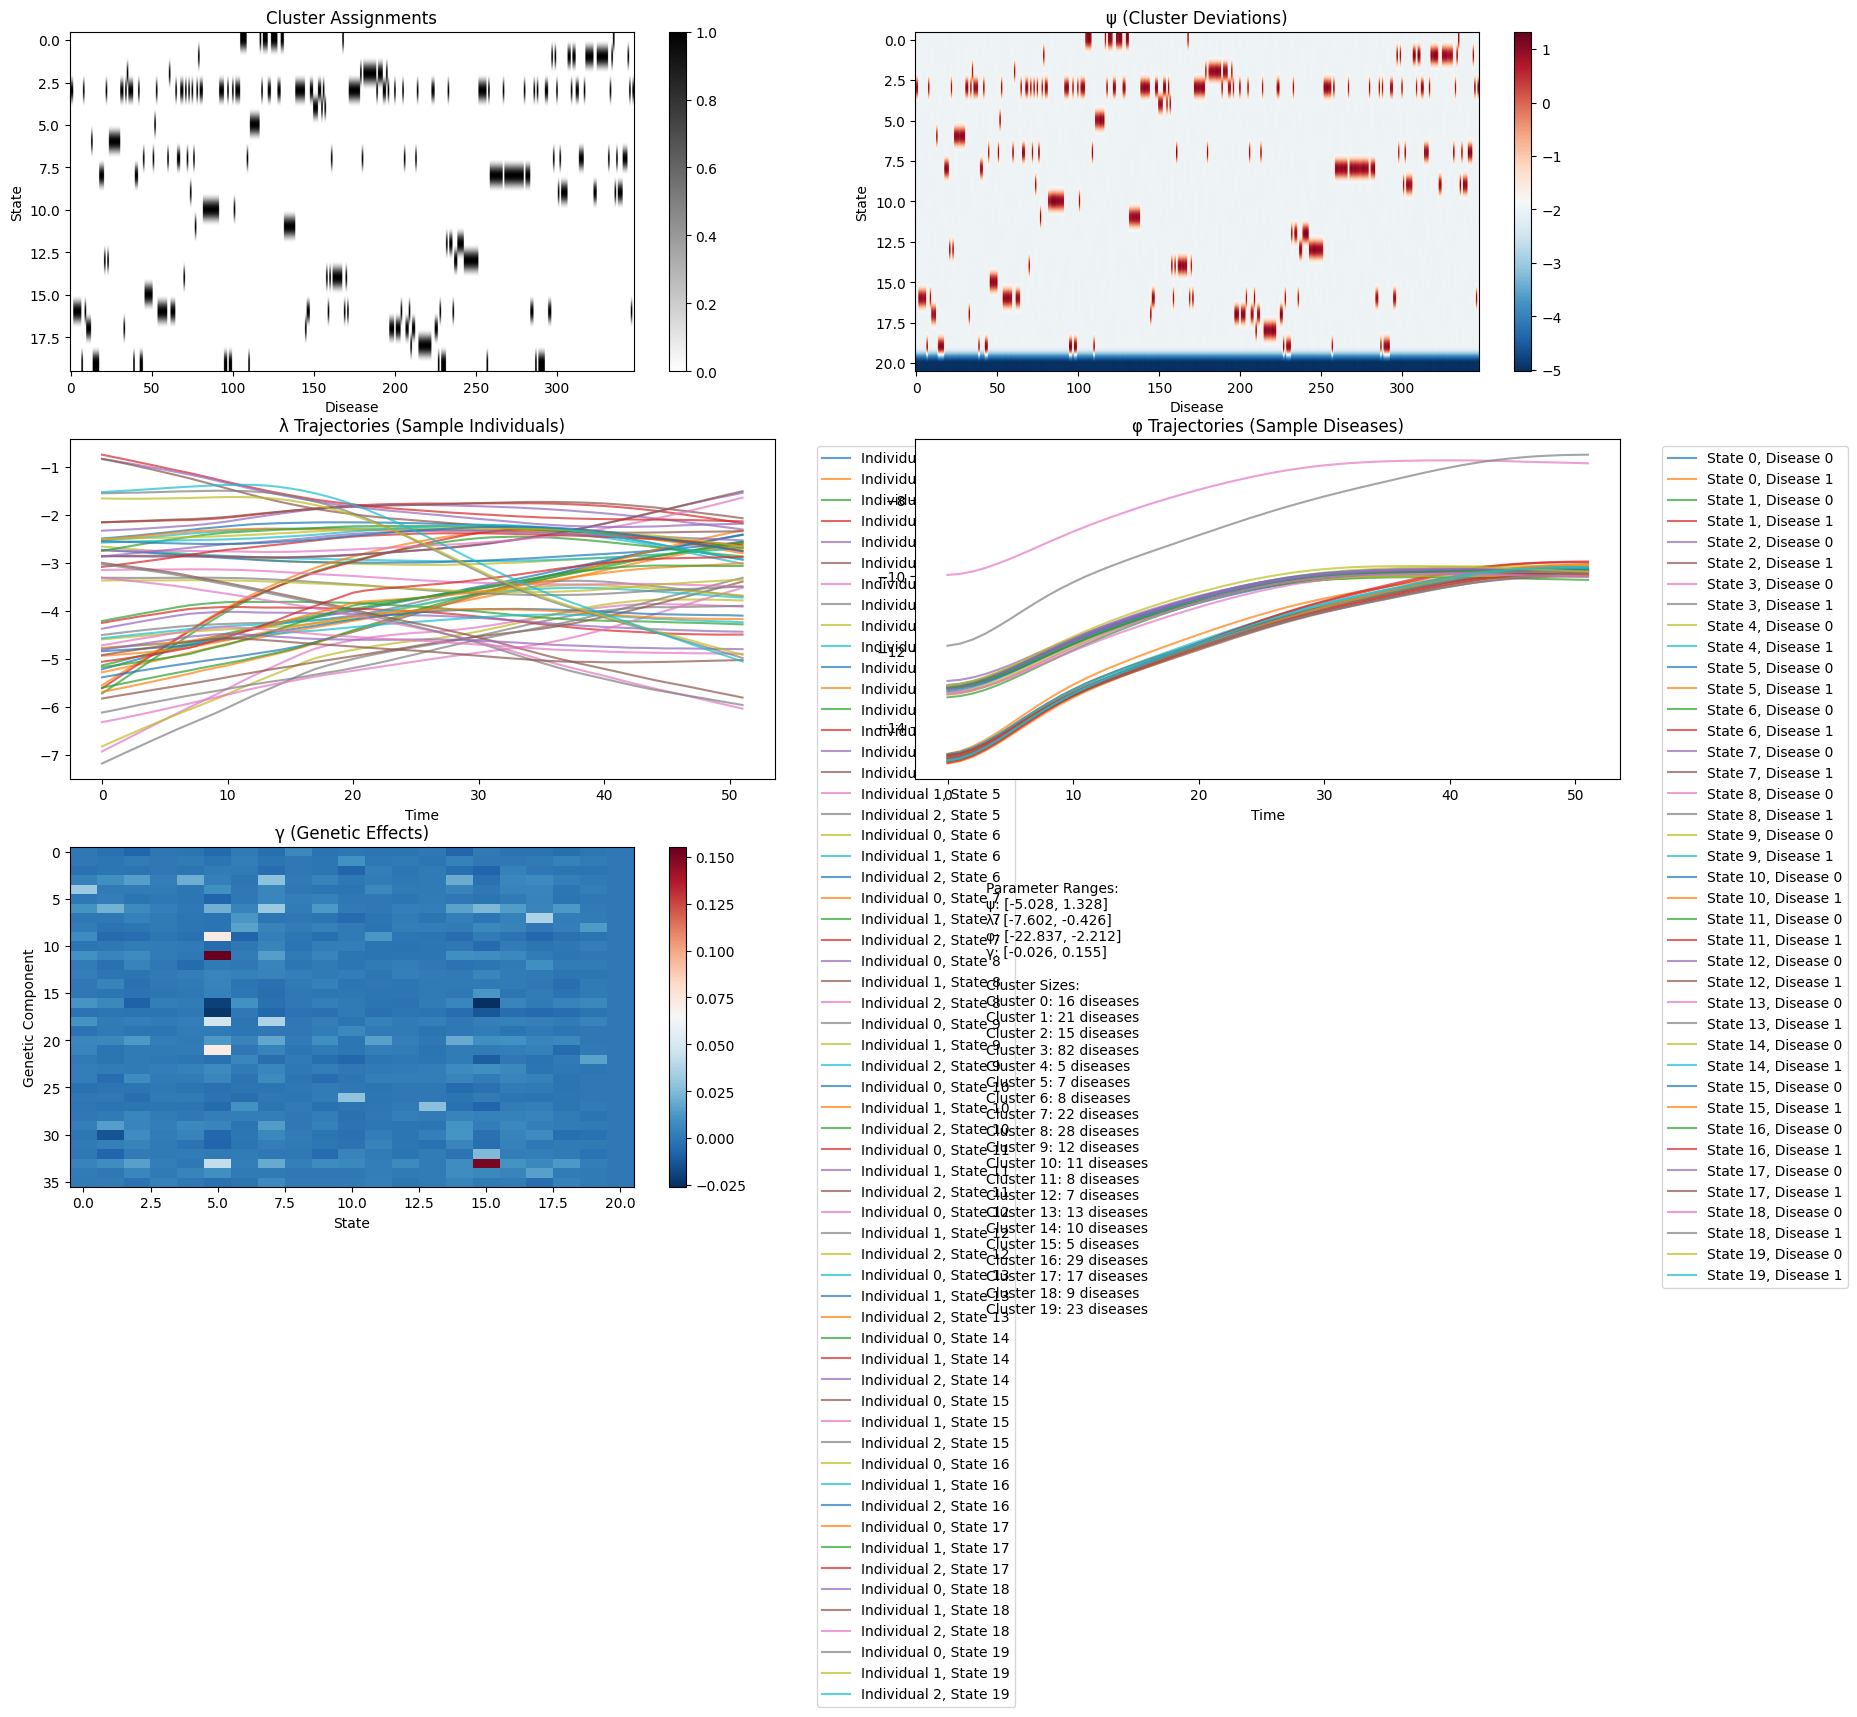

In [7]:
# Example: How to use pre-computed clusters/psi in your model
# (No need to initialize the model twice anymore!)

import sys
sys.path.append('/Users/sarahurbut/aladynoulli2/pyScripts_forPublish')
from clust_huge_amp_vectorized import *

# Load pre-computed files (created by Steps 1-3 above)
initial_psi = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_psi_400k.pt')
initial_clusters = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/initial_clusters_400k.pt')
prevalence_t = torch.load('/Users/sarahurbut/Library/CloudStorage/Dropbox-Personal/data_for_running/prevalence_t_corrected.pt')

# Create model with your data
model = AladynSurvivalFixedKernelsAvgLoss_clust_logitInit_psitest(
    N=Y.shape[0], 
    D=Y.shape[1], 
    T=Y.shape[2], 
    K=20,
    P=G.shape[1],
    init_sd_scaler=1e-1,
    G=G, 
    Y=Y,
    genetic_scale=1,
    W=0.0001,
    R=0,
    prevalence_t=prevalence_t,
    signature_references=signature_refs,  # From Step 3
    healthy_reference=True,  # Or None, depending on your setup
    disease_names=essentials.get('disease_names', None)
)

# Initialize with pre-computed psi and clusters (no need to recompute!)
model.initialize_params(true_psi=initial_psi)
model.clusters = initial_clusters

# Verify clusters match
clusters_match = np.array_equal(initial_clusters, model.clusters)
print(f"\nClusters match exactly: {clusters_match}")

# Now you can use the model for training/prediction!
model.visualize_initialization()  # Optional: visualize the initialization